In [ ]:
from zipfile import ZipFile
import glob
from skimage.io import imread
from skimage.color import gray2rgb
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
dataset_path = '/content/drive/MyDrive/CSE428_LAB/Project/Group_2.zip'
dataset_path = '/content/drive/MyDrive/Group_2.zip'
with ZipFile(dataset_path, 'r') as zip:
  zip.extractall()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    '/content/Group_2/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Group_2/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

def residual_block(x, filters, kernel_size=3, stride=1, dropout_rate=0.2):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    x = layers.Dropout(dropout_rate)(x)

    return x

def build_resnet50(input_shape=(224, 224, 3), num_classes=5, dropout_rate=0.2):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = residual_block(x, 64, dropout_rate=dropout_rate)
    x = residual_block(x, 64, dropout_rate=dropout_rate)
    x = residual_block(x, 128, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, 128, dropout_rate=dropout_rate)
    x = residual_block(x, 256, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, 256, dropout_rate=dropout_rate)
    x = residual_block(x, 512, stride=2, dropout_rate=dropout_rate)
    x = residual_block(x, 512, dropout_rate=dropout_rate)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=x)
    return model

model = build_resnet50(input_shape=(224, 224, 3), num_classes=len(train_generator.class_indices), dropout_rate=0.2)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[reduce_lr]
)


Found 2164 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/50
68/68 [==============================] - 47s 514ms/step - loss: 1.3256 - accuracy: 0.5305 - val_loss: 2.8817 - val_accuracy: 0.2880 - lr: 0.0010
Epoch 2/50
68/68 [==============================] - 30s 439ms/step - loss: 1.0457 - accuracy: 0.5799 - val_loss: 1.9702 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 3/50
68/68 [==============================] - 31s 458ms/step - loss: 0.9938 - accuracy: 0.6063 - val_loss: 1.5444 - val_accuracy: 0.3640 - lr: 0.0010
Epoch 4/50
68/68 [==============================] - 30s 438ms/step - loss: 0.9764 - accuracy: 0.5989 - val_loss: 1.6742 - val_accuracy: 0.4120 - lr: 0.0010
Epoch 5/50
68/68 [==============================] - 30s 447ms/step - loss: 0.9263 - accuracy: 0.6275 - val_loss: 1.3796 - val_accuracy: 0.4840 - lr: 0.0010
Epoch 6/50
68/68 [==============================] - 30s 445ms/step - loss: 0.9234 - accuracy: 0.6349 - val_loss: 1.2640 - val_accuracy: 0

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

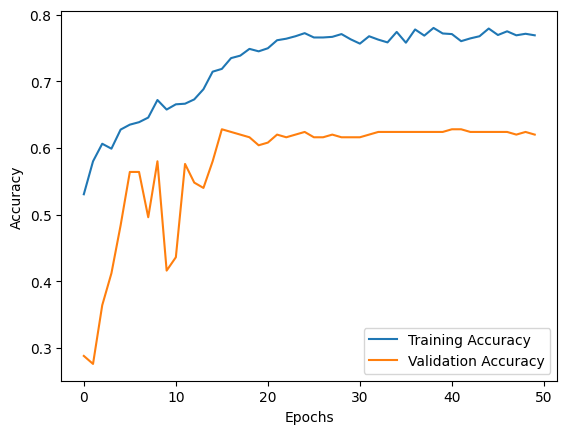

In [ ]:
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


8/8 [==============================] - 0s 49ms/step - loss: 0.8659 - accuracy: 0.6200
Test Accuracy: 62.00%


8/8 [==============================] - 1s 62ms/step
Classification Report:
               precision    recall  f1-score   support

     bighorn       0.23      0.28      0.25        50
   butterfly       0.22      0.22      0.22        50
       camel       0.18      0.22      0.20        50
  chimpanzee       0.22      0.26      0.24        50
         pig       0.27      0.12      0.17        50

    accuracy                           0.22       250
   macro avg       0.23      0.22      0.22       250
weighted avg       0.23      0.22      0.22       250



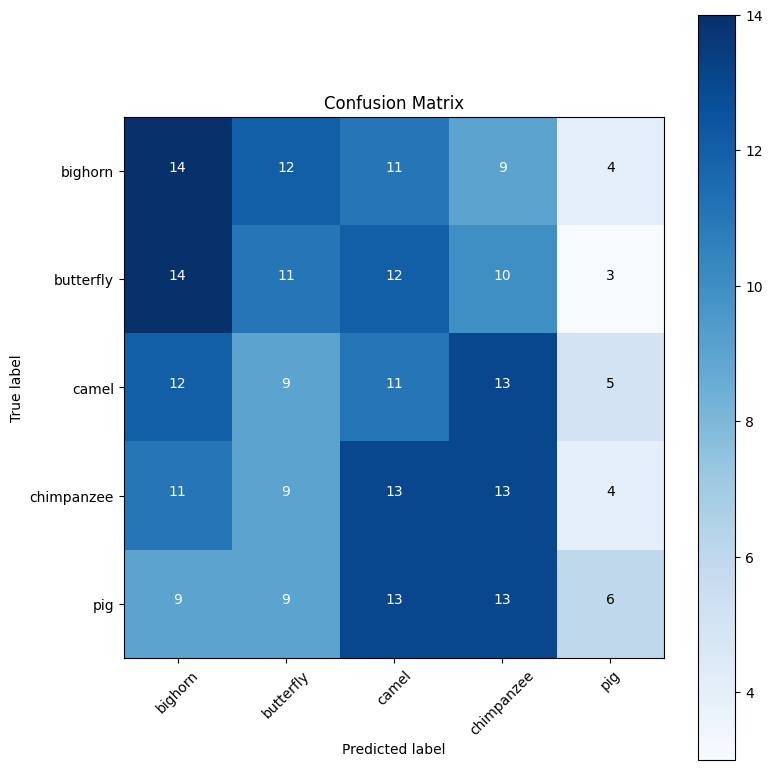

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes


conf_matrix = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(train_generator.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=classes))
plt.show()
